<div style="background-color: #c3e8fb; padding: 10px; color: #144d84;">
<b>Exercise 1) Hand Region Regression</b><br>
Using the dataset from:
https://class.vision/blog/diverse-hand-gesture-recognition-dataset/ Train a localization model for the hand region. At this stage, you don't need labels; you only need the hand region.

Note that the label format differs from the exercise, and the labels are in YOLO format, which you can learn about and convert by searching.
</div>

<div style="background-color: #c3e8fb; padding: 10px; color: #144d84;">
<b>Exercise 2) Regression + Classification</b><br>
Using the previous dataset, perform localization along with classification simultaneously using the functional API.
</div>

<div style="background-color: #c3e8fb; padding: 10px; color: #144d84;">
<b>Exercise 3) Testing on Webcam</b><br>
Test the model trained in the previous part on a webcam. Draw a rectangle around the hand and display the detected gesture. Make sure to send a short video of the code execution.
</div>

___

In [ ]:
# ! wget http://dl.deepnn.ir/Diverse_hand_gesture_dataset.zip
# !unzip -qq Diverse_hand_gesture_dataset.zip

We do the task with only 2000 samples of the dataset.  
as we want to proceed faster when training.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/My_Datasets_Repo/Hand_gesture_light_2000.zip', 'r') as zip_ref:
    zip_ref.extractall('extracted_files/')

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
# from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

from PIL import Image
from sklearn.model_selection import train_test_split
import random

### Preprocessing the Data

In [ ]:
train_folder = r'extracted_files/Hand_gesture_light_2000/train'
file_names = [f for f in os.listdir(train_folder) if os.path.isfile(os.path.join(train_folder, f)) and f.endswith('.png')]
random.shuffle(file_names)

In [ ]:
len(file_names)

2000

Taking 1600 of the training data to have a faster training

In [ ]:
images = []
targets = []
labels = []
count = 0

# Load images and labels
for filename in file_names:
    img_path = os.path.join(train_folder, filename)
    image = Image.open(img_path).convert('RGB')
    images.append(np.array(image))

    label_filename = filename.replace('.png', '.txt')
    label_path = os.path.join(train_folder, label_filename)

    with open(label_path, 'r') as f:
        for line in f:
            # Read the YOLO format: class x_center y_center width height
            parts = list(map(float, line.strip().split()))
            class_label = int(parts[0])
            x_center = parts[1]
            y_center = parts[2]
            width = parts[3]
            height = parts[4]

            # Append to targets and labels
            targets.append([x_center, y_center, width, height])
            labels.append(class_label)
    count+=1
    if count==2000:
        break

# Convert lists to numpy arrays
images = np.array(images).astype('float32') / 255.0
targets =  np.array(targets)
labels = np.array(labels)

print(f'Loaded {len(images)} images and {len(labels)} labels.')

Loaded 2000 images and 2000 labels.


In [ ]:
num_classes = len(np.unique(labels))
num_classes

8

In [ ]:
images[1].shape

(224, 224, 3)

In [ ]:
targets[158]

array([0.473214, 0.633929, 0.357143, 0.696429])

In [ ]:
labels[158]

5

In [ ]:
split_at = 1600

train_images = images[:split_at]
train_targets = targets[:split_at]
train_lables = labels[:split_at]

val_images = images[split_at:]
val_targets = targets[split_at:]
val_labels = labels[split_at:]

### Localization Task

In [ ]:
base_model = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,790,820 (56.42 MB)

 Trainable params: 76,132 (297.39 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
opt = Adam(learning_rate=1e-4)
model.compile(loss="mse", optimizer=opt)

In [ ]:
H = model.fit(
train_images, train_targets,
validation_data=(val_images, val_targets),
batch_size=32,
epochs=20,
verbose=1)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 571ms/step - loss: 0.0420 - val_loss: 0.0251
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 181ms/step - loss: 0.0244 - val_loss: 0.0216
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - loss: 0.0205 - val_loss: 0.0201
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - loss: 0.0205 - val_loss: 0.0193
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - loss: 0.0198 - val_loss: 0.0187
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - loss: 0.0192 - val_loss: 0.0185
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - loss: 0.0202 - val_loss: 0.0183
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - loss: 0.0193 - val_loss: 0.0181
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - loss: 0.0189 - val_loss: 0.0178
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - loss: 0.0187 - val_loss: 0.0176
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - loss: 0.0179 - val_loss: 0.0173
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 164

___

### Localization and  Classification (functional)

In [ ]:
num_classes = len(np.unique(labels))

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [ ]:
input_layer = Input(shape=(224, 224, 3))
x = base_model(input_layer)
x = GlobalAveragePooling2D()(x)

x1 =  Dense(32, activation='relu')(x)
bbox_output = Dense(4, activation="sigmoid", name='bbox_output')(x1)

x2 =  Dense(32, activation='relu')(x)
class_output = Dense(num_classes, activation='softmax', name='class_output')(x2)

model = tf.keras.models.Model(inputs=input_layer, outputs=[bbox_output, class_output])

In [ ]:
losses = {'bbox_output': 'mean_squared_error', 'class_output': 'sparse_categorical_crossentropy'}
metrics = {'bbox_output': 'mae', 'class_output': 'accuracy'}

model.compile(optimizer='adam',
              loss=losses,
              metrics=metrics)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 512)            │              0 │ vgg16[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │         16,416 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │         16,416 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bbox_output (Dense)       │ (None, 4)              │            132 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ class_output (Dense)      │ (None, 8)              │            264 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,747,916 (56.26 MB)

 Trainable params: 33,228 (129.80 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
trainTargets = {"bbox_output": train_targets, "class_output": train_lables}
valTargets = {"bbox_output": val_targets, "class_output": val_labels}

H = model.fit(
train_images, trainTargets,
validation_data=(val_images, valTargets),
batch_size=32,
epochs=40,
verbose=1)

Epoch 1/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 38s 380ms/step - bbox_output_loss: 0.0247 - bbox_output_mae: 0.1267 - class_output_accuracy: 0.1424 - class_output_loss: 2.1079 - loss: 2.1325 - val_bbox_output_loss: 0.0191 - val_bbox_output_mae: 0.1095 - val_class_output_accuracy: 0.1725 - val_class_output_loss: 2.0470 - val_loss: 2.0659
Epoch 2/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - bbox_output_loss: 0.0189 - bbox_output_mae: 0.1097 - class_output_accuracy: 0.2092 - class_output_loss: 2.0294 - loss: 2.0482 - val_bbox_output_loss: 0.0174 - val_bbox_output_mae: 0.1054 - val_class_output_accuracy: 0.2850 - val_class_output_loss: 1.9696 - val_loss: 1.9879
Epoch 3/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - bbox_output_loss: 0.0174 - bbox_output_mae: 0.1051 - class_output_accuracy: 0.2565 - class_output_loss: 1.9609 - loss: 1.9783 - val_bbox_output_loss: 0.0165 - val_bbox_output_mae: 0.1011 - val_class_output_accuracy: 0.3275 - val_class_output_loss: 1.9183 - val_loss: 1.9362
Epoch 4/40
50/

In [ ]:
# 10 more epochs
H2 = model.fit(
train_images, trainTargets,
validation_data=(val_images, valTargets),
initial_epoch=40,
batch_size=32,
epochs=50,
verbose=1)

Epoch 41/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step - bbox_output_loss: 0.0058 - bbox_output_mae: 0.0590 - class_output_accuracy: 0.8347 - class_output_loss: 0.6281 - loss: 0.6340 - val_bbox_output_loss: 0.0079 - val_bbox_output_mae: 0.0681 - val_class_output_accuracy: 0.7500 - val_class_output_loss: 0.7847 - val_loss: 0.7900
Epoch 42/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - bbox_output_loss: 0.0057 - bbox_output_mae: 0.0584 - class_output_accuracy: 0.8301 - class_output_loss: 0.5981 - loss: 0.6039 - val_bbox_output_loss: 0.0076 - val_bbox_output_mae: 0.0668 - val_class_output_accuracy: 0.7900 - val_class_output_loss: 0.7542 - val_loss: 0.7600
Epoch 43/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - bbox_output_loss: 0.0058 - bbox_output_mae: 0.0590 - class_output_accuracy: 0.8493 - class_output_loss: 0.5971 - loss: 0.6029 - val_bbox_output_loss: 0.0075 - val_bbox_output_mae: 0.0666 - val_class_output_accuracy: 0.7425 - val_class_output_loss: 0.7783 - val_loss: 0.7828
Epoch 44/50
5

In [95]:
model.save('localization_classification_vgg_model.h5')
model.save('localization_classification_vgg_model.keras')
model.save_weights('localization_classification_vgg_model.weights.h5')

___

### Testing on webcam

In [ ]:
# model = tf.keras.models.load_model('localization_classification_vgg_model.keras')

In [23]:
def process_frame(frame):
    input_size = (224, 224)
    resized_frame = cv2.resize(frame, input_size)
    normalized_frame = resized_frame.astype('float32') / 255.0
    normalized_frame = np.expand_dims(normalized_frame, axis=0)

    bbox_pred, class_pred = model.predict(normalized_frame)

    bbox_pred = bbox_pred[0]
    class_index = np.argmax(class_pred[0])

    return bbox_pred, class_index

In [ ]:
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    bbox_pred, class_index = process_frame(frame)

    h, w, _ = frame.shape
    x_center = int(bbox_pred[0] * w)
    y_center = int(bbox_pred[1] * h)
    width = int(bbox_pred[2] * w)
    height = int(bbox_pred[3] * h)

    x_min = int(x_center - width / 2)
    y_min = int(y_center - height / 2)

    cv2.rectangle(frame, (x_min, y_min), (x_min + width, y_min + height), (255, 0, 0), 2)

    label_text = f'Class: {class_index}'
    cv2.putText(frame, label_text, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    cv2.imshow('Webcam Feed', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

___

Testing on a few images of test data

In [66]:
label_names = ['zero', 'dislike', 'five', 'exactly' ,'two', 'three', 'left', 'like']
# 0 zero
# 1 dislike
# 2 five
# 3 exactly
# 4 two
# 5 three
# 6 left
# 7 like

In [90]:
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array


def predict_and_annotate(image_path):
    image_to_be_annotated=cv2.imread(image_path)

    input_image = preprocess_image(image_path)
    bbox_prediction, class_prediction = model.predict(input_image)


    height, width, _ = image_to_be_annotated.shape

    for i in range(len(bbox_prediction)):
        x_center, y_center, box_width, box_height = bbox_prediction[i]

        x0 = int((x_center - box_width / 2) * width)
        y0 = int((y_center - box_height / 2) * height)

        x1 = int((x_center + box_width / 2) * width)
        y1 = int((y_center + box_height / 2) * height)

        cv2.rectangle(image_to_be_annotated, (x0, y0), (x1, y1), color=(200, 0, 200), thickness=2)

        label = class_prediction[i]
        cv2.putText(image_to_be_annotated, label_names[np.argmax(class_prediction[0])], (x0, y0 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 255), thickness=2)

    plt.imshow(image_to_be_annotated[:,:,::-1])
    cv2.imwrite('annotated_image.jpg', image_to_be_annotated)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


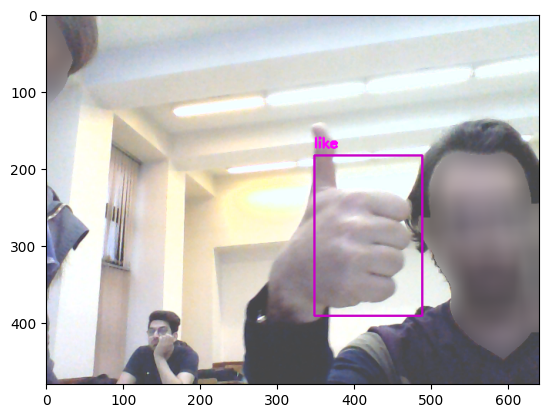

In [91]:
image_path = '10763.png'
predict_and_annotate(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


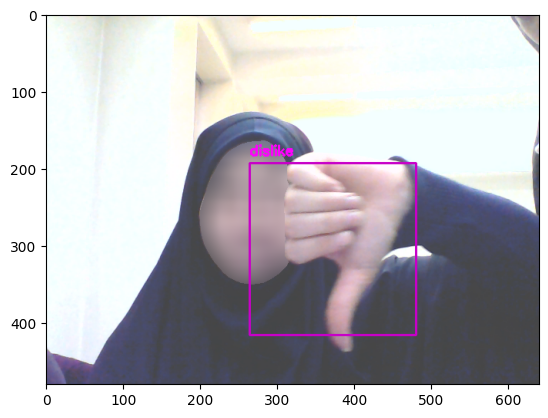

In [92]:
image_path = '12073.png'
predict_and_annotate(image_path)